In [1]:
import pynq #Library for FPGA control
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

def load_ppm(filename):
    with open(filename, 'rb') as f:
        # Read header
        magic = f.readline().strip()
        if magic != b'P6':
            raise ValueError("Not a P6 PPM file")

        # Read width, height (skipping comments)
        def read_non_comment():
            line = f.readline()
            while line.startswith(b'#'):
                line = f.readline()
            return line

        dims = read_non_comment()
        width, height = map(int, dims.split())

        # Read max color value (usually 255)
        maxval = int(read_non_comment())
        if maxval > 255:
            raise ValueError("Only 8-bit PPM supported")

        # Read raw RGB data
        img = np.frombuffer(f.read(), dtype=np.uint8)
        img = img.reshape((height, width, 3))

        return img

In [2]:
assert pynq.__version__ == "3.0.1", f"v{pynq.__version__}, 3.0.1 is the latest one to support Alveo XRT"
for i in range(len(pynq.Device.devices)): #List FPGA devices attached to the system
    print("{}) {}".format(i, pynq.Device.devices[i].name))

0) xilinx_u55c_gen3x16_xdma_base_3


In [3]:
currentDevice = pynq.Device.devices[0]
xclbin = '../_x.xilinx_u55c_gen3x16_xdma_3_202210_1/sobel.xclbin'
ol = pynq.Overlay(xclbin,device=currentDevice) #Load bitstream
#If this runs forever, the FPGA was not "freed" after someone programmed it last
# reset it by running the terminal command: xbutil reset -d 0000:01:00.1 --force
# then try again.

In [4]:
#List kernels available in the device
ol.ip_dict

{'mm2p_0': {'phys_addr': 16777216,
  'addr_range': 28,
  'type': 'xilinx.com:hls:mm2p:1.0',
  'hw_control_protocol': 'ap_ctrl_chain',
  'fullpath': 'mm2p_0',
  'registers': {'CTRL': {'address_offset': 0,
    'access': 'read-write',
    'size': 4,
    'description': 'OpenCL Control Register',
    'type': 'unsigned int',
    'id': None,
    'fields': {'AP_START': {'access': 'read-write',
      'bit_offset': 0,
      'bit_width': 1,
      'description': 'Start the accelerator'},
     'AP_DONE': {'access': 'read-only',
      'bit_offset': 1,
      'bit_width': 1,
      'description': 'Accelerator has finished - cleared on read'},
     'AP_IDLE': {'access': 'read-only',
      'bit_offset': 2,
      'bit_width': 1,
      'description': 'Accelerator is idle'},
     'AP_READY': {'access': 'read-only',
      'bit_offset': 3,
      'bit_width': 1,
      'description': 'Accelerator is ready to start next computation'},
     'AUTO_RESTART': {'access': 'read-write',
      'bit_offset': 7,
      'bi

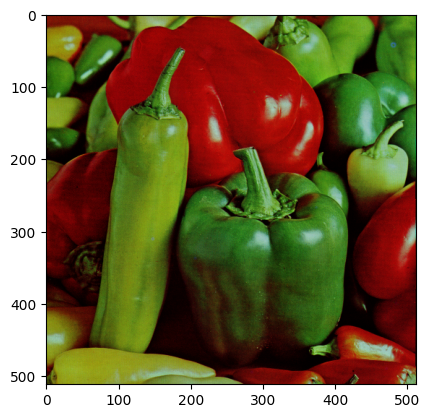

In [5]:
img = load_ppm("../data/in0.ppm") #Load image
plt.imshow(img) #Show the input image
plt.show()

In [6]:
shape = img.shape
input_buf = pynq.allocate(shape, dtype=np.uint8, target=ol.HBM0) #Allocate buffers in FPGA DRAM(HBM)
output_buf = pynq.allocate((*shape[:2], 1), dtype=np.uint8, target=ol.HBM0)
mm2p = ol.mm2p_0 #This is just setting an alias for the mm2p and p2mm instances, not actually required
p2mm = ol.p2mm_0

In [7]:
input_buf[:] = img #Write image to the host copy of the input_buf buffer
input_buf.sync_to_device() #Move the buffer over PCIe DMA to the FPGA memory
wait_p2mm = p2mm.start(output_buf) #Start the p2mm kernel
sleep(0.01) #For some reason at least I missed a few rows if I started these directly after each other, maybe some larger FIFOs in the design would also fix it.
wait_mm2p = mm2p.start(input_buf) #Start the mm2p kernel
wait_mm2p.wait() #Wait for mm2p to finnish
wait_p2mm.wait() #Wait for p2mm to finnish
output_buf.sync_from_device() #Read the output_buf from FPGA memory to host memory

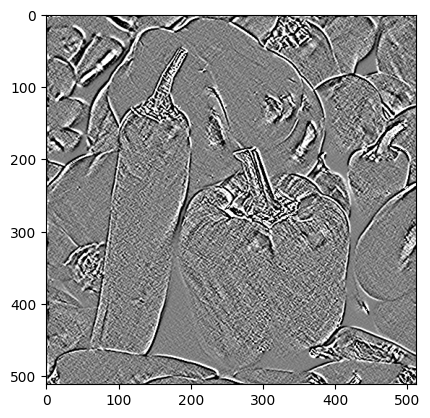

In [8]:
plt.imshow(output_buf, cmap='gray') #Show the results
plt.show()

In [9]:
#Free all resources
input_buf.freebuffer()
output_buf.freebuffer()
ol.free()